In [13]:
import pymssql
from datetime import datetime, timedelta
from tqdm import tqdm_notebook
import json

import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
columns = ['id', 'author', 'permlink', 'title', 'body','body_language']

server, user, password, db = ('vip.steemsql.com', 'db_username', 'db_passwd', 'DBSteem')
conn = pymssql.connect(server, user, password, db)
cursor = conn.cursor()

# Get data 

Fetch data for last year from SteemSQL

In [4]:
def get_posts_in_interval(start, end):
    query = '''
    SELECT id, author, permlink, body_language, beneficiaries, total_payout_value, net_votes, children, 
    json_metadata, created, curator_payout_value
    FROM Comments
    WHERE parent_author = ''
    AND created BETWEEN '{}' AND '{}'
    '''.format(start, end)
    cursor.execute(query)
    data = cursor.fetchall()
    posts = pd.DataFrame(data, columns=['id', 'author', 'permlink', 'body_language', 'beneficiaries', 
                                        'total_payout_value', 'net_votes', 'children', 'json_metadata', 
                                        'created', 'curator_payout_value'])
    return posts

In [5]:
intervals = [
    ['2018-10-01 00:00:00', '2018-10-31 23:59:59'],
    ['2018-09-01 00:00:00', '2018-09-30 23:59:59'],
    ['2018-08-01 00:00:00', '2018-08-31 23:59:59'],
    ['2018-07-01 00:00:00', '2018-07-31 23:59:59'],
    ['2018-06-01 00:00:00', '2018-06-30 23:59:59'],
    ['2018-05-01 00:00:00', '2018-05-31 23:59:59'],
    ['2018-04-01 00:00:00', '2018-04-30 23:59:59'],
    ['2018-03-01 00:00:00', '2018-03-31 23:59:59'],
    ['2018-02-01 00:00:00', '2018-02-28 23:59:59'],
    ['2018-01-01 00:00:00', '2018-01-31 23:59:59'],
]

In [6]:
posts = []
for i in tqdm_notebook(intervals):
    posts.append(get_posts_in_interval(i[0], i[1]))

In [7]:
posts_df = pd.concat(posts)

In [8]:
posts_df.to_csv('2018_beneficiares_stats.csv', index=False)

In [2]:
# posts_df = pd.read_csv('2018_beneficiares_stats.csv')

In [125]:
posts_df.shape

(9671014, 14)

# Prepare data

## Total posts

In [3]:
posts_df['has_beneficiares'] = posts_df.beneficiaries.apply(lambda b: False if b == '[]' else True)

In [49]:
month_map = {'01': 'Jan', '02': 'Feb', '03': 'Mar', '04': 'Apr', '05': 'May', '06': 'Jun', '07': 'Jul', '08': 'Aug',
            '09': 'Sep', '10': 'Oct'}
posts_df['created_str'] = posts_df.created.astype(str)
posts_df['month'] = posts_df.created_str.apply(lambda d: month_map[d[5:7]])

In [62]:
posts_df.head()

,id,author,permlink,body_language,beneficiaries,total_payout_value,net_votes,children,json_metadata,created,curator_payout_value,has_beneficiares,created_str,month
0,61753305,yurim,my-very-own-personal-photography-23,"[{""language"":""ko"",""isReliable"":true,""confidenc...",[],0.430,1,0,"{""tags"":[""kr"",""kr-daily"",""photography"",""travel...",2018-10-19 21:26:42,0.140,False,2018-10-19 21:26:42,Oct
1,63479578,gooddeal,20181001t000004801z,"[{""language"":""ko"",""isReliable"":true,""confidenc...",[],0.230,3,1,"{""tags"":[""kr"",""coinkorea"",""kr-event"",""jjangjja...",2018-10-01 00:00:06,0.070,False,2018-10-01 00:00:06,Oct
2,63479576,mr-freeman,utilize-customized-systems-1538352000776,"[{""language"":""en"",""isReliable"":false,""confiden...",[],0.050,4,0,"{""tags"":[""meme"",""funny"",""memes"",""freeman""],""im...",2018-10-01 00:00:00,0.010,False,2018-10-01 00:00:00,Oct
3,63479573,steemeum,steemeum-day-31,"[{""language"":""en"",""isReliable"":true,""confidenc...",[],0.180,22,2,"{""tags"":[""steemeum""]}",2018-10-01 00:00:00,0.050,False,2018-10-01 00:00:00,Oct
4,63434503,kingxeno,small-talk-is-useless,"[{""language"":""en"",""isReliable"":true,""confidenc...",[],0.000,3,3,"{""tags"":[""people"",""blogs"",""education"",""non"",""p...",2018-10-01 04:58:48,0.000,False,2018-10-01 04:58:48,Oct


In [63]:
posts_df.total_payout_value.sum()

24251197.19999996

## Benefeciares subset

In [4]:
with_benef = posts_df.loc[posts_df.has_beneficiares != False]

Normalize beneficiaries field into two separate fields:

In [5]:
with_benef.beneficiaries = with_benef.beneficiaries.apply(lambda d: json.loads(d))
with_benef['benef_acc'] = with_benef.beneficiaries.apply(lambda d: d[0]['account'])
with_benef['benef_weight'] = with_benef.beneficiaries.apply(lambda d: d[0]['weight'] / 100)

/home/cvlt/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/cvlt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/cvlt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.

## Beneficiary percent distribution

Text(0.5,0,'Beneficiary percent')

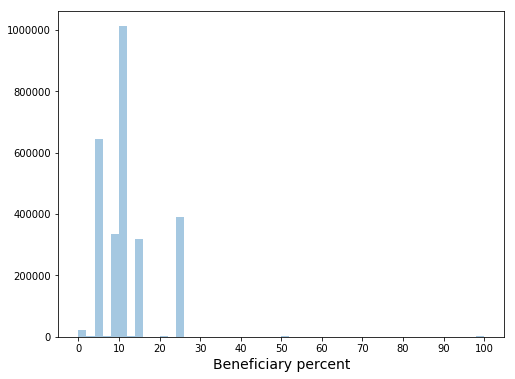

In [76]:
import matplotlib.ticker as ticker

plt.figure(figsize=(8,6))
ax = sns.distplot(with_benef.benef_weight, kde=False)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.xlabel('Beneficiary percent', fontsize=14)

In [67]:
with_benef.benef_weight.describe()

count   2734576.000
mean         11.431
std           6.772
min           0.000
25%           9.000
50%          10.000
75%          15.000
max         100.000
Name: benef_weight, dtype: float64

In [6]:
with_benef = with_benef.drop(['beneficiaries'], axis=1)

In [20]:
with_benef = with_benef.drop(['body_language'], axis=1)

Count author and beneficiary payouts from total_payout_value and curator_payout_value:

In [7]:
with_benef['author_payout_value'] = with_benef.total_payout_value - with_benef.curator_payout_value
with_benef.author_payout_value = with_benef.author_payout_value.astype('float64')
with_benef['benef_payout_value'] = with_benef.benef_weight * with_benef.author_payout_value / 100

## Beneficiary payouts total sum

In [47]:
with_benef.benef_payout_value.sum()

401249.87771400006

In [10]:
with_benef.to_csv('with_benef.csv', index=False)

In [8]:
with_benef['date'] = with_benef.created.apply(lambda d: d[:10])

In [9]:
with_benef.head()

,id,author,permlink,body_language,total_payout_value,net_votes,children,json_metadata,created,curator_payout_value,has_beneficiares,benef_acc,benef_weight,author_payout_value,benef_payout_value,date
0,63479599,buffalo-goku,organictradeassociationsuestheusdaforrefusingt...,"[{""language"":""en"",""isReliable"":true,""confidenc...",0.000,2,1,"{""community"":""steempress"",""app"":""steempress/1....",2018-10-01 00:00:24,0.000,True,steempress,15.000,0.000,0.000,2018-10-01
1,63479596,earthship,an-introductuon-to-thuja-oil-da95fad2c8bef,"[{""language"":""en"",""isReliable"":true,""confidenc...",0.020,1,0,"{""links"":[""https://www.naturalnews.com/2018-09...",2018-10-01 00:00:24,0.010,True,esteemapp,10.000,0.010,0.001,2018-10-01
2,63479592,kravas,oh-lord-jesus-its-a-fire-zg1hbmlh-rq3xb,"[{""language"":""en"",""isReliable"":true,""confidenc...",0.090,1,0,"{""tags"":[""dmania"",""video"",""funny"",""fire"",""dman...",2018-10-01 00:00:18,0.040,True,cnts,5.000,0.050,0.003,2018-10-01
3,63479672,rongibsonchannel,7h4j8g90,"[{""language"":""en"",""isReliable"":true,""confidenc...",0.000,2,0,"{""video"":{""info"":{""title"":""ALEX JONES (2nd HOU...",2018-10-01 00:02:42,0.000,True,dtube,10.000,0.000,0.000,2018-10-01
4,63479673,zurichtimes,gip78wys,"[{""language"":""en"",""isReliable"":true,""confidenc...",0.000,1,0,"{""video"":{""info"":{""title"":""Part B SkyScraper T...",2018-10-01 00:02:45,0.000,True,dtube,10.000,0.000,0.000,2018-10-01


In [10]:
with_benef_dates = with_benef.groupby('date').benef_payout_value.sum().reset_index()

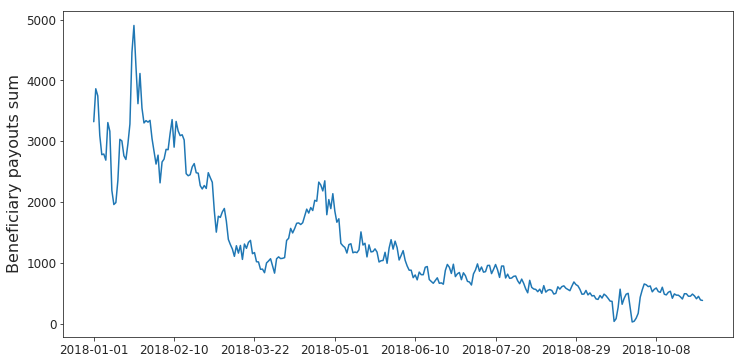

In [20]:
plt.figure(figsize=(12,6))

ax = sns.lineplot(x='date', y='benef_payout_value', data=with_benef_dates)

ax.xaxis.set_major_locator(ticker.MultipleLocator(40))
plt.ylabel('Beneficiary payouts sum', fontsize=16)
plt.xlabel('', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

# Count stats

In [37]:
len(with_benef.benef_acc.unique())

1591

In [11]:
benef_post_count = with_benef.groupby('benef_acc').id.count().reset_index().sort_values('id', ascending=False).rename(columns={'id': 'post_count'})

In [12]:
benef_author_count = with_benef.groupby('benef_acc').author.nunique().reset_index().sort_values('author', ascending=False).rename(columns={'author': 'author_count'})

In [13]:
benef_total_pay_sum = with_benef.groupby('benef_acc').total_payout_value.sum().reset_index().sort_values('total_payout_value', ascending=False).rename(columns={'total_payout_value': 'total_payout_sum'})

## Beneficiary payout sum

In [14]:
benef_pay_sum = with_benef.groupby('benef_acc').benef_payout_value.sum().reset_index().sort_values('benef_payout_value', ascending=False).rename(columns={'benef_payout_value': 'benef_payout_sum'})

In [15]:
benef_author_count.head()

,benef_acc,author_count
776,esteemapp,46956
716,dtube,39349
1511,steepshot,17333
690,dmania,11639
517,cnts,10043


In [16]:
# benef_post_count = benef_post_count.set_index('benef_acc')
#benef_pay_sum = benef_pay_sum.set_index('benef_acc')
# benef_author_count = benef_author_count.set_index('benef_acc')

for acc in tqdm_notebook(benef_post_count.index.values):
    benef_post_count.loc[acc, 'benef_pay_sum'] = benef_pay_sum.loc[acc].benef_payout_sum
    benef_post_count.loc[acc, 'author_count'] = benef_author_count.loc[acc].author_count

In [17]:
benef_post_count = benef_post_count.reset_index()

In [18]:
benef_post_count.loc[benef_post_count.benef_pay_sum > 100].shape

(36, 5)

## Top beneficiaries

In [19]:
valuable = benef_post_count.iloc[:10]

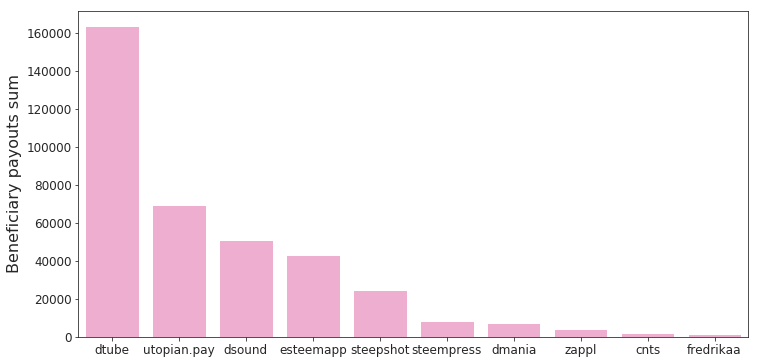

In [44]:
plt.figure(figsize=(12,6))

# sns.set(font_scale = 1.1)
valuable = valuable.sort_values('benef_pay_sum', ascending=False)

sns.barplot(x='benef_acc', 
            y='benef_pay_sum', 
            data=valuable, 
            order=valuable.benef_acc, 
            color='#f7a4cfff')
sns.set_style("ticks", {"xtick.major.size": 10, "ytick.minor.size": 14})
plt.ylabel('Beneficiary payouts sum', fontsize=16)
plt.xlabel('', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=12)

Check values with another table

In [4]:
query = '''
    SELECT SUM(vesting_payout)
    FROM VOCommentBenefactorRewards
    WHERE benefactor = 'dtube'
    '''
cursor.execute(query)
data = cursor.fetchall()

In [14]:
from steem.converter import Converter
c = Converter()

In [16]:
c.vests_to_sp(float(data[0][0]))

168287.12516770203

75% of beneficiaries received less than 283 SBD

In [56]:
benef_post_count.loc[benef_post_count.benef_pay_sum > 10].benef_pay_sum.describe()

count       94.000
mean      4273.069
std      19464.094
min         10.242
25%         18.119
50%         49.164
75%        283.864
max     163810.365
Name: benef_pay_sum, dtype: float64

In [27]:
top_5 = benef_post_count.sort_values('benef_pay_sum', ascending=False).iloc[:5]
other = benef_post_count.sort_values('benef_pay_sum', ascending=False).iloc[5:]
other = other.loc[other.benef_pay_sum > 0]
top_5

,index,benef_acc,post_count,benef_pay_sum,author_count
2,716,dtube,306093,163810.365,39349.000
9,1555,utopian.pay,43717,69433.495,4217.000
8,715,dsound,56037,51158.412,5693.000
0,776,esteemapp,1067903,42972.751,46956.000
1,1511,steepshot,341010,24850.409,17333.000


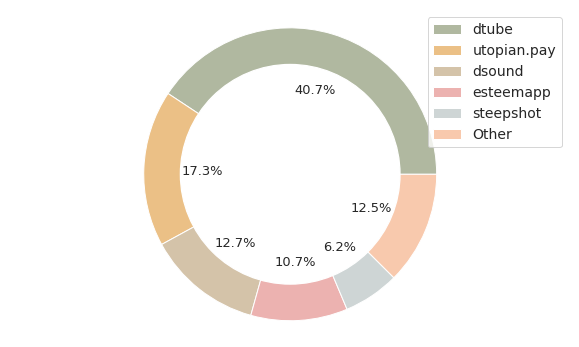

In [45]:
draw_donut(
    list(top_5.benef_acc.values) + ['Other'], 
    list(top_5.benef_pay_sum) + [other.benef_pay_sum.sum()],
    '',
    ['#B0B8A0', '#EBC086', '#D4C3A9', '#ECB2B0', '#CED5D5', '#F8C9AD', '#88ACB2', '#D37A81']
)

# Count ratios

In [21]:
with_benef_count = posts_df.loc[posts_df.beneficiaries != '[]'].shape[0]

In [19]:
without_benef_count = posts_df.loc[posts_df.beneficiaries == '[]'].shape[0]

In [22]:
with_benef_count

2734576

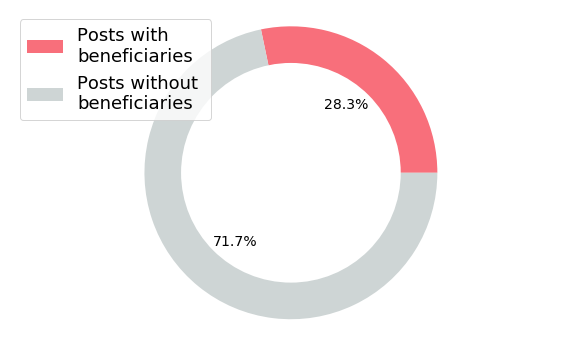

In [48]:
draw_donut(
    ['Posts with \nbeneficiaries', 'Posts without \nbeneficiaries'], 
    [with_benef_count, without_benef_count],
    '',#'Posts count ratio',
    ['#F86F7B', '#CED5D5']
)

In [49]:
with_benef_pay_sum = posts_df.loc[posts_df.beneficiaries != '[]'].total_payout_value.sum()

In [56]:
posts_df.loc[posts_df.beneficiaries != '[]'].total_payout_value.describe()

count   2734576.000
mean          1.364
std           7.716
min           0.000
25%           0.000
50%           0.030
75%           0.440
max         982.110
Name: total_payout_value, dtype: float64

In [50]:
without_benef_pay_sum = posts_df.loc[posts_df.beneficiaries == '[]'].total_payout_value.sum()

In [57]:
posts_df.loc[posts_df.beneficiaries == '[]'].total_payout_value.describe()

count   6936438.000
mean          2.959
std          14.637
min           0.000
25%           0.000
50%           0.060
75%           0.830
max        1967.320
Name: total_payout_value, dtype: float64

In [53]:
with_benef_pay_sum

3728646.8699999982

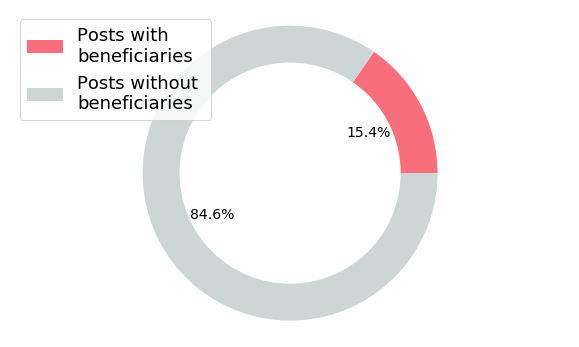

In [52]:
draw_donut(
    ['Posts with \nbeneficiaries', 'Posts without \nbeneficiaries'], 
    [with_benef_pay_sum, without_benef_pay_sum],
    '', #'Posts with/without benefitiares payout sum ratio',
    ['#F86F7B', '#CED5D5']
)

In [50]:
months = ['Oct', 'Sep', 'Aug']
three_months = posts_df.loc[posts_df.month.isin(months)]
three_months.shape[0]

1597009

In [51]:
three_months.total_payout_value = three_months.total_payout_value.astype('float64')

/home/cvlt/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [122]:
three_months['total_payout_value_log'] = three_months.total_payout_value.apply(lambda p: np.log(p))

/home/cvlt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [63]:
three_months.head()

,id,author,permlink,body_language,beneficiaries,total_payout_value,net_votes,children,json_metadata,created,curator_payout_value,has_beneficiares,created_str,month,total_payout_value_log
0,61753305,yurim,my-very-own-personal-photography-23,"[{""language"":""ko"",""isReliable"":true,""confidenc...",[],0.43,1,0,"{""tags"":[""kr"",""kr-daily"",""photography"",""travel...",2018-10-19 21:26:42,0.14,False,2018-10-19 21:26:42,Oct,-0.843970
1,63479578,gooddeal,20181001t000004801z,"[{""language"":""ko"",""isReliable"":true,""confidenc...",[],0.23,3,1,"{""tags"":[""kr"",""coinkorea"",""kr-event"",""jjangjja...",2018-10-01 00:00:06,0.07,False,2018-10-01 00:00:06,Oct,-1.469676
2,63479576,mr-freeman,utilize-customized-systems-1538352000776,"[{""language"":""en"",""isReliable"":false,""confiden...",[],0.05,4,0,"{""tags"":[""meme"",""funny"",""memes"",""freeman""],""im...",2018-10-01 00:00:00,0.01,False,2018-10-01 00:00:00,Oct,-2.995732
3,63479573,steemeum,steemeum-day-31,"[{""language"":""en"",""isReliable"":true,""confidenc...",[],0.18,22,2,"{""tags"":[""steemeum""]}",2018-10-01 00:00:00,0.05,False,2018-10-01 00:00:00,Oct,-1.714798
4,63434503,kingxeno,small-talk-is-useless,"[{""language"":""en"",""isReliable"":true,""confidenc...",[],0.00,3,3,"{""tags"":[""people"",""blogs"",""education"",""non"",""p...",2018-10-01 04:58:48,0.00,False,2018-10-01 04:58:48,Oct,-inf


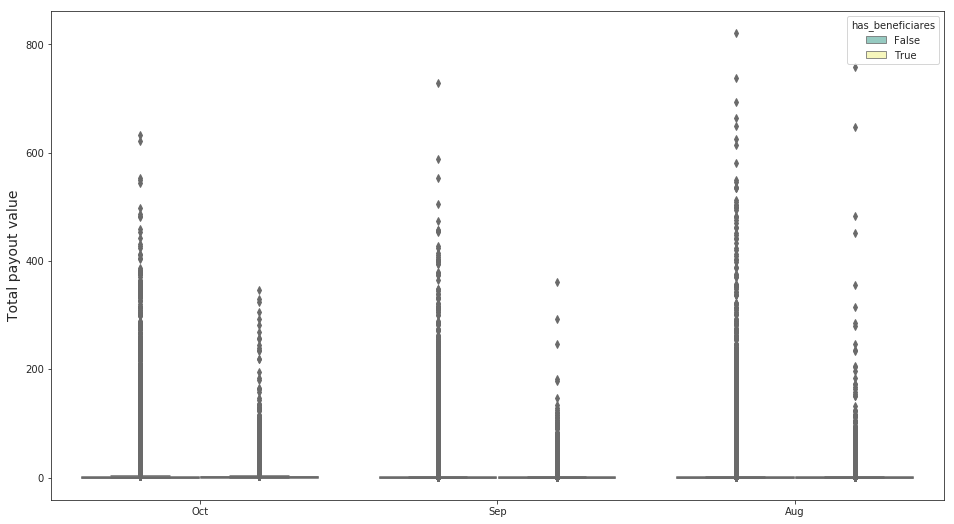

In [53]:
plt.figure(figsize=(16,9))
sns.boxplot(x="month", y="total_payout_value", hue="has_beneficiares", data=three_months, palette="Set3")
plt.xlabel('')
plt.ylabel('Total payout value', fontsize=14)
plt.show()

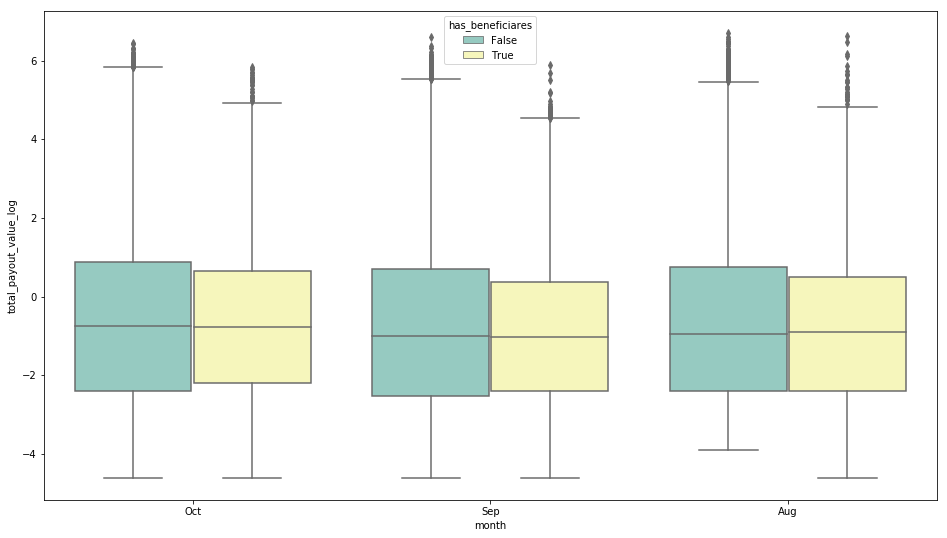

In [124]:
plt.figure(figsize=(16,9))
sns.boxplot(x="month", 
            y="total_payout_value_log", 
            hue="has_beneficiares", 
            data=three_months.loc[three_months.total_payout_value_log != float('-inf')], 
            palette="Set3")
plt.show()

# Suplementary methods

In [ ]:
def draw_donut(labels, sizes, title, colors=None):
    if colors == None:
        colors = ['#C2A0BA', '#F86F7B', '#90C1B5', '#DED780']

    plt.figure(figsize=(10,6))
    patches, texts, some = plt.pie(sizes, colors=colors, autopct='%1.1f%%', textprops={'fontsize': 13})
    
    
    centre_circle = plt.Circle((0,0), 0.75, fc='white',linewidth=1.25)
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    plt.legend(patches, labels, loc="best", fontsize=14)
    plt.title(title, fontsize=22)
    plt.axis('equal')
    plt.show()